In [234]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, validation_curve
import os
import hyperopt
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.preprocessing import StandardScaler
import time
import seaborn as sns
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import log_loss, d2_pinball_score, get_scorer_names
from sklearn.utils import resample

from sklearn.metrics import mean_absolute_error

import math

import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.metrics import mean_squared_error, mean_pinball_loss, make_scorer, accuracy_score, balanced_accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_recall_fscore_support, r2_score

from google.colab import drive
from os import listdir
from os.path import isfile, join
from joblib import dump, load


from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingRandomSearchCV, LeaveOneOut
from pprint import pprint


drive.mount('/content/drive')

PATH = '/content/drive/MyDrive/nda'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Note on the following function:

This is a work-around to accomodate the fact that in the TrainModels file we forgot to save the cross validation score of the optimized classifier. Since that file takes a long time to finish running, we did this workaround in a countained function for easy deletion in the future. This workaround simply loads the classifier, re-runs a cross validation procedure on the model, and then re-fits the model to the training data.

In [235]:
def delete_soon():

  def eval_model_classifier(y_true1, y_pred1):
    y_true = np.array(y_true1, dtype=float)
    y_pred = np.array(y_pred1, dtype=float)
    accuracy = accuracy_score(y_true, y_pred)
    precision, recall, fscore, support = precision_recall_fscore_support(y_true, y_pred, zero_division = 0)
    under = np.sum(y_true > y_pred)
    over = np.sum(y_true < y_pred)
    correct = np.sum(y_true == y_pred)
    miss_rate = (over+under)/ (correct+over+under)

    results = {'Accuracy': accuracy,
              'Precision': precision.mean(),
              'Recall': recall.mean(),
              'FScore': fscore.mean(),
              'Under Allocations': under,
              'Over Allocations': over,
              'Correct Allocations': correct,
              'Miss Rate': miss_rate}

    return results

  model_path = PATH + '/models'
  model_e = load(join(model_path, 'opt150_classifier_e.joblib'))
  opt_clf_etrain_cv = cross_val_score(model_e, E_train, e_train_mf).mean()
  model_e.fit(E_train, e_train_mf)
  opt_clf_etrain_res = eval_model_classifier(e_train_mf, model_e.predict(E_train))
  opt_clf_etrain_res['Cross Validation'] = opt_clf_etrain_cv
  metrics_e = {}
  metrics_e['Opt_Clf_e'] = opt_clf_etrain_res
  opt_clf_etrain_df = pd.DataFrame.from_dict(metrics_e, orient='index')

  model_g = load(join(model_path, 'opt150_classifier_g.joblib'))
  opt_clf_gtrain_cv = cross_val_score(model_g, G_train, g_train_mf).mean()
  model_g.fit(G_train, g_train_mf)

  opt_clf_gtrain_res = eval_model_classifier(g_train_mf, model_g.predict(G_train))
  opt_clf_gtrain_res['Cross Validation'] = opt_clf_gtrain_cv
  metrics_g = {}
  metrics_g['Opt_Clf_g'] = opt_clf_gtrain_res
  opt_clf_gtrain_df = pd.DataFrame.from_dict(metrics_g, orient='index')

  return opt_clf_etrain_df, opt_clf_gtrain_df

# Loading the data, models and metrics

In [236]:
# SNR to MF function
boundries = [8.7, 12.8, 15.2, 18.2, 21.0]

def SNR_to_MF(SNR):
    epsilon = 1e-6  # Small epsilon value for comparison

    if SNR < boundries[0] - epsilon:
        return 0

    elif (boundries[0] - epsilon <= SNR) and (SNR < boundries[1]):
        return 4

    elif (boundries[1] <= SNR) and (SNR < boundries[2]):
        return 8

    elif (boundries[2] <= SNR) and (SNR < boundries[3]):
        return 16

    elif (boundries[3] <= SNR) and (SNR < boundries[4]):
        return 32

    else:  # SNR >= 23.7:
        return 64


# Load the already-split Data
split_data_path = PATH + '/split_data/'

E_train = np.loadtxt(join(split_data_path, 'E_train.out'), delimiter=',')
G_train = np.loadtxt(join(split_data_path,'G_train.out'), delimiter=',')
E_test = np.loadtxt(join(split_data_path,'E_test.out'), delimiter=',')
G_test = np.loadtxt(join(split_data_path,'G_test.out'), delimiter=',')

e_train_snr = np.loadtxt(join(split_data_path,'e_train_snr.out'), delimiter=',')
g_train_snr = np.loadtxt(join(split_data_path,'g_train_snr.out'), delimiter=',')
e_test_snr = np.loadtxt(join(split_data_path,'e_test_snr.out'), delimiter=',')
g_test_snr = np.loadtxt(join(split_data_path,'g_test_snr.out'), delimiter=',')

e_train_mf = [str(SNR_to_MF(x)) for x in e_train_snr]
e_test_mf = [str(SNR_to_MF(x)) for x in e_test_snr]
g_train_mf = [str(SNR_to_MF(x)) for x in g_train_snr]
g_test_mf = [str(SNR_to_MF(x)) for x in g_test_snr]


# Load the Models
model_path = PATH + '/models/'

# E/G Classifier Models (Default and Optimized)
clf_def_e = load(join(model_path, 'def_classifier_e.joblib'))
clf_def_g = load(join(model_path, 'def_classifier_g.joblib'))
clf_opt_e = load(join(model_path, 'opt150_classifier_e.joblib'))
clf_opt_g = load(join(model_path, 'opt150_classifier_g.joblib'))

# E/G 50% Regressor Models (Default and Optimized)
def_q5regressor_e = load(join(model_path, 'def_q5regressor_e.joblib'))
def_q5regressor_g = load(join(model_path, 'def_q5regressor_g.joblib'))
Q050_pb050_e = load(join(model_path, 'Q0.90_pb0.90_e.joblib'))
Q050_pb050_g = load(join(model_path, 'Q0.90_pb0.90_g.joblib'))


# Load the Metrics
metrics_path = PATH + '/metrics/'

# Regressor Metrics
regtrain_models_metrics_e = pd.read_csv(join(metrics_path, 'all_metrics_etrain.csv'), index_col=0)
regtrain_models_metrics_g = pd.read_csv(join(metrics_path, 'all_metrics_gtrain.csv'), index_col=0)
regtrain_def_metrics_e = pd.read_csv(join(metrics_path, 'all_metrics_q5def_etrain.csv'), index_col=0)
regtrain_def_metrics_g = pd.read_csv(join(metrics_path, 'all_metrics_q5def_gtrain.csv'), index_col=0)

# Classifier Metrics
clftrain_opt_metrics_e, clftrain_opt_metrics_g = delete_soon()
clftrain_def_metrics_e = pd.read_csv(join(metrics_path, 'all_metrics_clfdef_etrain.csv'))
clftrain_def_metrics_g = pd.read_csv(join(metrics_path, 'all_metrics_clfdef_gtrain.csv'))



#Print Model parameters to compare default and optimized models

In [237]:
clf_def_e.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'log_loss',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': None,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [238]:
clf_opt_e.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.24563060794923214,
 'loss': 'log_loss',
 'max_depth': 2,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 27,
 'min_samples_split': 7,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 65,
 'n_iter_no_change': None,
 'random_state': 11,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [239]:
clf_def_g.get_params()


{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'log_loss',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': None,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [240]:
clf_opt_g.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.33646423098832695,
 'loss': 'log_loss',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 25,
 'min_samples_split': 30,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 55,
 'n_iter_no_change': None,
 'random_state': 11,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [241]:
def_q5regressor_e.get_params()


{'alpha': 0.9,
 'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'quantile',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': None,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [242]:
Q050_pb050_e.get_params()

{'alpha': 0.9,
 'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.19454710696540278,
 'loss': 'quantile',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 13,
 'min_samples_split': 9,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 85,
 'n_iter_no_change': None,
 'random_state': 11,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [243]:
def_q5regressor_g.get_params()

{'alpha': 0.9,
 'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'quantile',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': None,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [244]:
Q050_pb050_g.get_params()

{'alpha': 0.9,
 'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.48228580970024987,
 'loss': 'quantile',
 'max_depth': 2,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 14,
 'min_samples_split': 27,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 80,
 'n_iter_no_change': None,
 'random_state': 11,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [245]:
PENALIZE_OVER = 0
PENALIZE_UNDER = 1

def eval_model(y_true, y_pred, alpha):
  mse = mean_squared_error(y_true, y_pred)
  pbl = mean_pinball_loss(y_true, y_pred, alpha=0.5)
  pbo = mean_pinball_loss(y_true, y_pred, alpha=PENALIZE_OVER)
  pbu = mean_pinball_loss(y_true, y_pred, alpha=PENALIZE_UNDER)
  pba = mean_pinball_loss(y_true, y_pred, alpha=alpha)
  mae = mean_absolute_error(y_true, y_pred)
  r2 = r2_score(y_true, y_pred)
  d2 = d2_pinball_score(y_true, y_pred)
  aic, bic = aic_bic(y_true, y_pred, alpha)
  mf_true = np.array([SNR_to_MF(x) for x in y_true])
  mf_pred = np.array([SNR_to_MF(x) for x in y_pred])
  under = np.sum(mf_true > mf_pred)
  over = np.sum(mf_true < mf_pred)
  correct = np.sum(mf_true == mf_pred)
  miss_rate = (over+under)/ (correct+over+under)

  results = {'Mean Squared Error':mse,
             'Mean Pinball Loss': pbl,
             'Pinball Loss At Alpha': pba,
             'Mean Absolute Error': mae,
             'R2 Square': r2,
             'D2 Pinball': d2,
             'AIC': aic,
             'BIC': bic,
             'Under Allocations': under,
             'Over Allocations': over,
             'Correct Allocations': correct,
             'Miss Rate': miss_rate}

  return results

def aic_bic(y_true, y_pred, q, verbose=False):
  residuals = y_true - y_pred
  scale = np.percentile(np.abs(residuals), 100*q)
  log_likelihood_est = np.log(q / scale) - q * np.abs(residuals) / scale
  n = len(y_true)
  k = 5
  aic = -2 * np.sum(log_likelihood_est) + 2 * k
  bic = -2 * np.sum(log_likelihood_est) + np.log(n) * k
  if verbose:
    print(f'AIC: {aic}')
    print(f'BIC: {bic}')
  return aic, bic


def eval_model_classifier(y_true1, y_pred1):
  y_true = np.array(y_true1, dtype=float)
  y_pred = np.array(y_pred1, dtype=float)
  accuracy = accuracy_score(y_true, y_pred)
  precision, recall, fscore, support = precision_recall_fscore_support(y_true, y_pred, zero_division = 0)
  under = np.sum(y_true > y_pred)
  over = np.sum(y_true < y_pred)
  correct = np.sum(y_true == y_pred)
  miss_rate = (over+under)/ (correct+over+under)
  results = {'Accuracy': accuracy,
              'Precision': precision.mean(),
              'Recall': recall.mean(),
              'FScore': fscore.mean(),
              'Under Allocations': under,
              'Over Allocations': over,
              'Correct Allocations': correct,
              'Miss Rate': miss_rate}

  return results


In [246]:
eval_model(g_test_snr, Q050_pb050_g.predict(G_test), 0.9)
#pineapple

{'Mean Squared Error': 0.10234366574408338,
 'Mean Pinball Loss': 0.13192310544472366,
 'Pinball Loss At Alpha': 0.032277449496111714,
 'Mean Absolute Error': 0.2638462108894473,
 'R2 Square': 0.9398320954144976,
 'D2 Pinball': 0.7438757442829185,
 'AIC': -43.77555784534865,
 'BIC': -24.70490518622332,
 'Under Allocations': 0,
 'Over Allocations': 39,
 'Correct Allocations': 296,
 'Miss Rate': 0.11641791044776119}

# Functions ready to use for plotting

In [247]:
def incremental_bar(data, data_markers, present_labels, empty_slots, x_label, y_label, ax, color='#1f77b4'):
  num_bars = len(data) + empty_slots
  x = range(num_bars)
  empty_labels = [''] * empty_slots
  labels = present_labels + empty_labels
  ax.bar(x, data + [0] * empty_slots, width=0.2, label=y_label, color=color)
  ax.set_xticks(x)
  ax.set_xticklabels(labels)
  ax.grid(axis='y')
  ax.set_xlabel(x_label)
  ax.set_ylabel(y_label)
  for i, marker in enumerate(data_markers):
      ax.plot([i - 0.1, i + 0.1], [marker, marker], color='red', linestyle='dashed')

  ax.set_xticks(x)
  ax.set_xticklabels(labels, rotation=45)
  ax.grid(axis='y')
  ax.set_xlabel(x_label)
  ax.set_ylabel(y_label)

  ax.set_title('Evaluating Progression of Model Performance')

  plt.show()

###For presentaion: Hyperoptimization Paramters: Classifiers [slide 17]

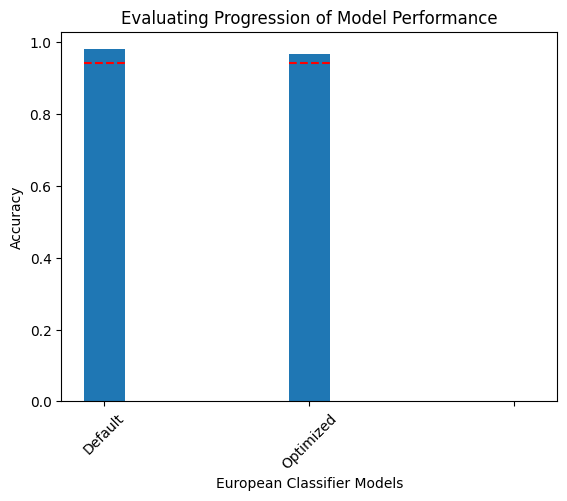

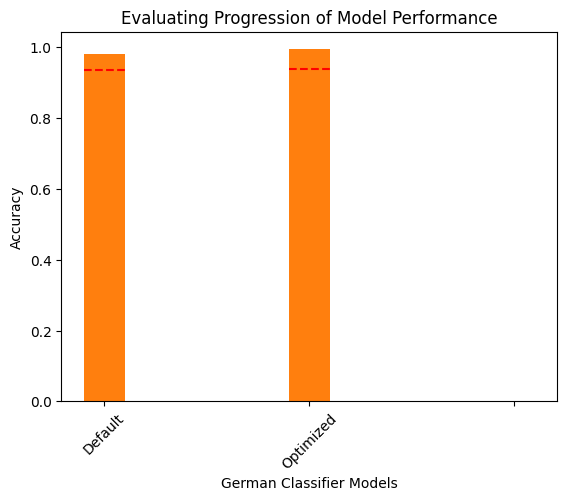

In [248]:
# Classifiers bar plots for Accuracy

g_clf_acc = [clftrain_def_metrics_g['Accuracy'].iloc[0], clftrain_opt_metrics_g['Accuracy'].iloc[0]]
g_clf_cv = [clftrain_def_metrics_g['Cross Validation'].iloc[0], clftrain_opt_metrics_g['Cross Validation'].iloc[0]]

e_clf_acc = [clftrain_def_metrics_e['Accuracy'].iloc[0], clftrain_opt_metrics_e['Accuracy'].iloc[0]]
e_clf_cv = [clftrain_def_metrics_e['Cross Validation'].iloc[0], clftrain_opt_metrics_e['Cross Validation'].iloc[0]]

incremental_bar(e_clf_acc, e_clf_cv, ['Default', 'Optimized'], 1, 'European Classifier Models', 'Accuracy', plt.gca())
incremental_bar(g_clf_acc, g_clf_cv, ['Default', 'Optimized'], 1, 'German Classifier Models', 'Accuracy', plt.gca(), color='#ff7f0e')

###For presentaion: Hyperoptimization Paramters: Regressors [slide 18]

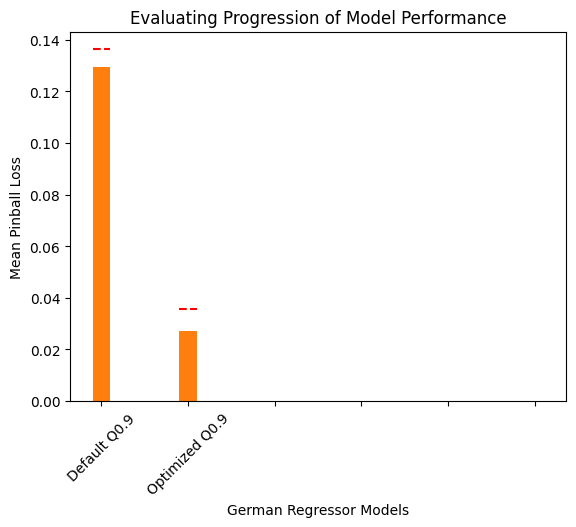

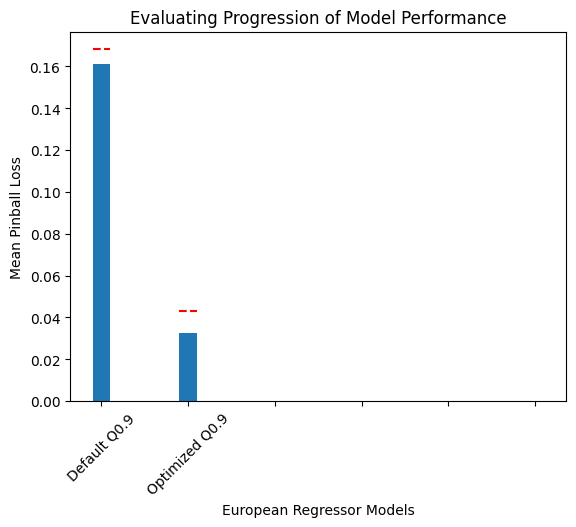

In [249]:
# Regressors bar plots for Loss

g_q_loss = [regtrain_def_metrics_g['Pinball Loss At Alpha'].iloc[0], regtrain_models_metrics_g['Pinball Loss At Alpha'].loc['Q0.90_pb0.90_g']]
g_q_cv = [regtrain_def_metrics_g['Cross Validation'].iloc[0], regtrain_models_metrics_g['Cross Validation'].loc['Q0.90_pb0.90_g']]

e_q_loss = [regtrain_def_metrics_e['Pinball Loss At Alpha'].iloc[0], regtrain_models_metrics_e['Pinball Loss At Alpha'].loc['Q0.90_pb0.90_e']]
e_q_cv = [regtrain_def_metrics_e['Cross Validation'].iloc[0], regtrain_models_metrics_e['Cross Validation'].loc['Q0.90_pb0.90_e']]

incremental_bar(g_q_loss, g_q_cv, ['Default Q0.9', 'Optimized Q0.9'], 4, 'German Regressor Models', 'Mean Pinball Loss', plt.gca(), color='#ff7f0e')
incremental_bar(e_q_loss, e_q_cv, ['Default Q0.9', 'Optimized Q0.9'], 4, 'European Regressor Models', 'Mean Pinball Loss', plt.gca())

In [250]:
def AIC_BIC_plots(metrics):

  fig, axes = plt.subplots(1,2,figsize=(20, 5))

  metrics['AIC'] = abs(metrics['AIC'])
  metrics_AICsorted = metrics.sort_values(by = ['AIC'])
  dataAIC = metrics_AICsorted.loc[:, ['AIC']]


  ax1 = sns.barplot(data=dataAIC, x=dataAIC.index, y=dataAIC['AIC'], ax=axes[0])
  ax1.set(ylabel = 'log AIC')
  ax1.set_yscale('log')
  ax1.tick_params(axis='x', rotation=90)

  metrics['BIC'] = abs(metrics['BIC'])
  metrics_BICsorted = metrics.sort_values(by = ['BIC'])
  metrics_BICnolast = metrics_BICsorted.iloc[:-1] # dropping sample with biggest BIC value to have a clearer plot
  dataBIC = metrics_BICnolast.loc[:, ['BIC']]

  ax2 = sns.barplot(data=dataBIC, x=dataBIC.index, y=dataBIC['BIC'], ax=axes[1])
  ax2.set(ylabel = 'log BIC')
  ax2.set_yscale('log')
  ax2.tick_params(axis='x', rotation=90)

  plt.show()
  return dataAIC, dataBIC

###For presentation Quantile Selection [slides 20-21]

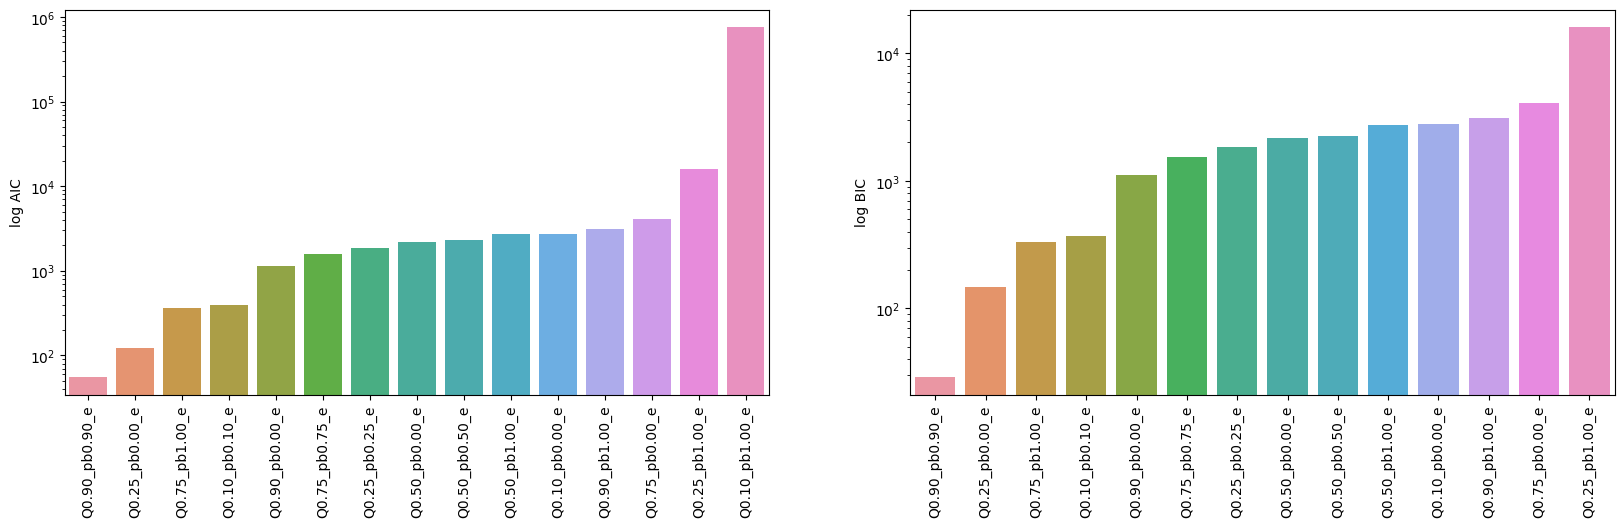

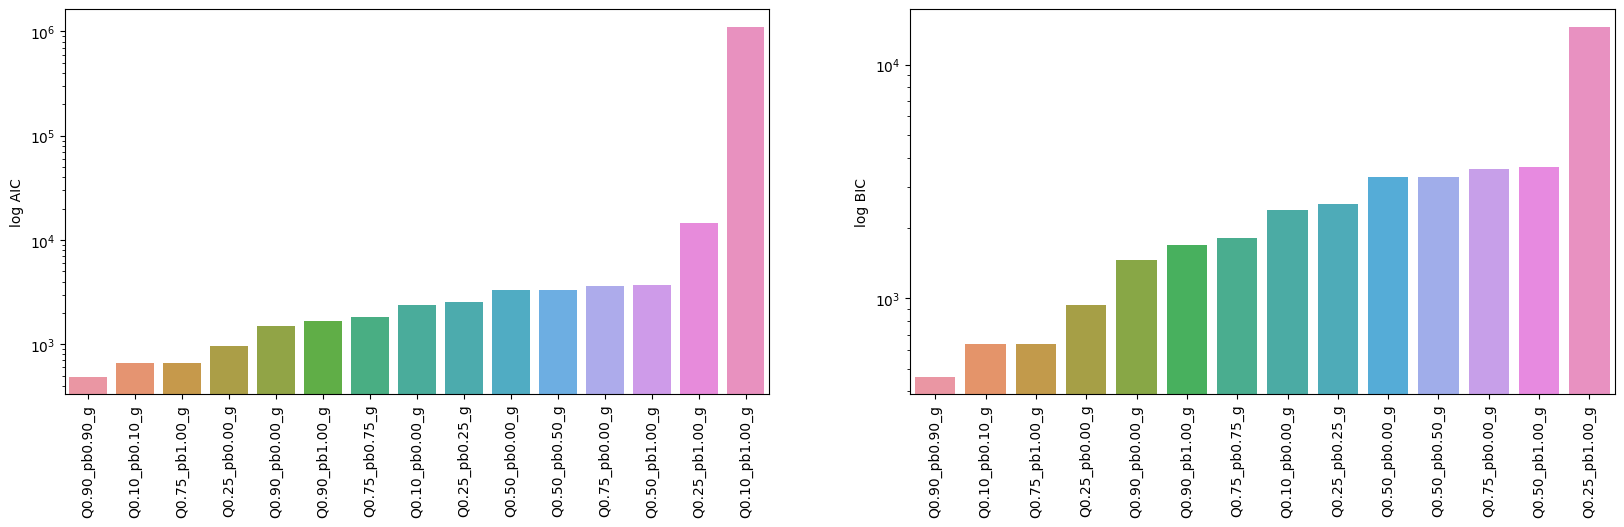

(                         AIC
 Q0.90_pb0.90_g  4.882589e+02
 Q0.10_pb0.10_g  6.618774e+02
 Q0.75_pb1.00_g  6.673527e+02
 Q0.25_pb0.00_g  9.588806e+02
 Q0.90_pb0.00_g  1.482825e+03
 Q0.90_pb1.00_g  1.670514e+03
 Q0.75_pb0.75_g  1.836855e+03
 Q0.10_pb0.00_g  2.368678e+03
 Q0.25_pb0.25_g  2.571547e+03
 Q0.50_pb0.00_g  3.327950e+03
 Q0.50_pb0.50_g  3.344602e+03
 Q0.75_pb0.00_g  3.614724e+03
 Q0.50_pb1.00_g  3.674235e+03
 Q0.25_pb1.00_g  1.449196e+04
 Q0.10_pb1.00_g  1.109559e+06,
                          BIC
 Q0.90_pb0.90_g    462.267990
 Q0.10_pb0.10_g    635.886468
 Q0.75_pb1.00_g    641.361743
 Q0.25_pb0.00_g    932.889687
 Q0.90_pb0.00_g   1456.834414
 Q0.90_pb1.00_g   1696.505173
 Q0.75_pb0.75_g   1810.864310
 Q0.10_pb0.00_g   2394.669334
 Q0.25_pb0.25_g   2545.556326
 Q0.50_pb0.00_g   3301.958937
 Q0.50_pb0.50_g   3318.610594
 Q0.75_pb0.00_g   3588.732812
 Q0.50_pb1.00_g   3648.244139
 Q0.25_pb1.00_g  14517.948533)

In [251]:
# All Quantile Regressor Models plots for AIC and BIC Scores

AIC_BIC_plots(regtrain_models_metrics_e)
AIC_BIC_plots(regtrain_models_metrics_g)

In [252]:
def allocations_plot(metrics):

  fig, ax = plt.subplots(1,1,figsize=(20, 5))
  data_allocations = metrics.loc[:, ['Under Allocations','Over Allocations','Correct Allocations']]
  models = data_allocations.index.values
  correct_allocations = data_allocations['Correct Allocations']
  under_allocations = data_allocations['Under Allocations']
  over_allocations = data_allocations['Over Allocations']

  bar_width = 0.2

  r1 = range(len(models))
  r2 = [x + bar_width for x in r1]
  r3 = [x + bar_width for x in r2]

  plt.bar(r1, correct_allocations, width=bar_width, label='Correct Allocations')
  plt.bar(r2, under_allocations, width=bar_width, label='Under Allocations')
  plt.bar(r3, over_allocations, width=bar_width, label='Over Allocations')

  plt.xticks([r + bar_width for r in range(len(models))], models, rotation = 90)
  plt.ylabel('Counts')
  plt.title('Allocation Metrics by Model')
  plt.grid()
  plt.legend()

  plt.show()
  return data_allocations


###For presentation Quantile Selection [slides 23-24]

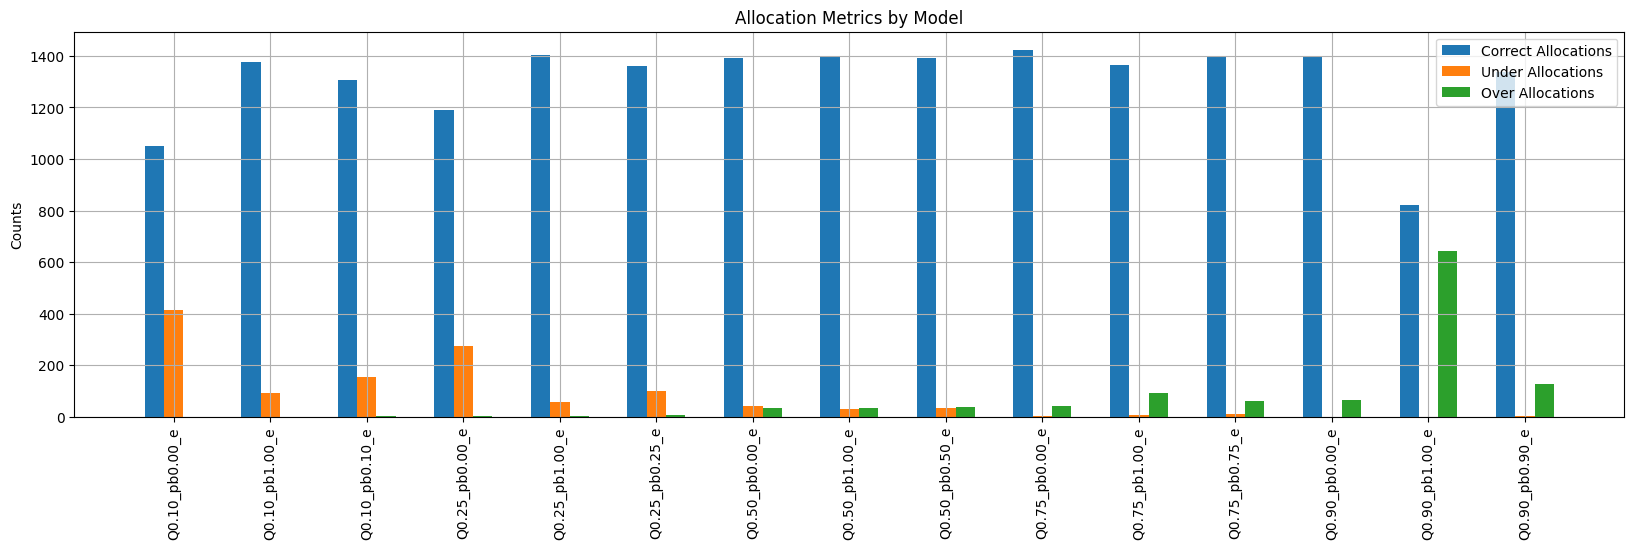

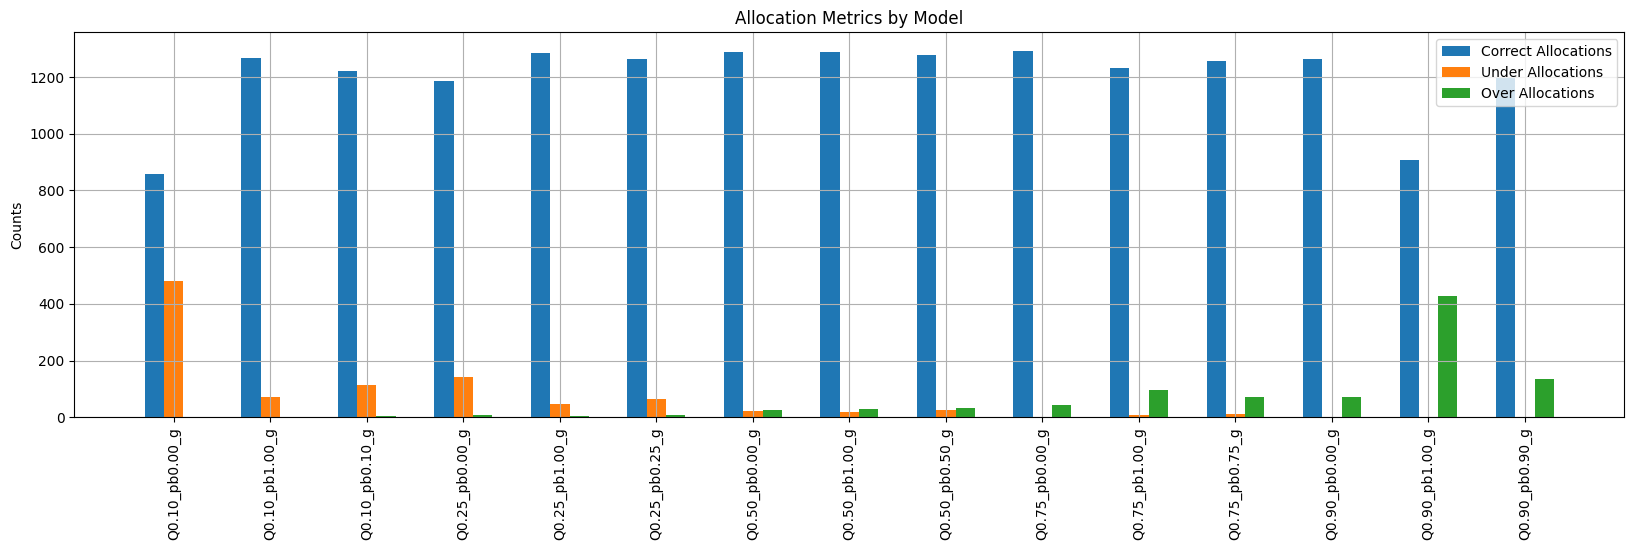

,Under Allocations,Over Allocations,Correct Allocations
Q0.10_pb0.00_g,479,0,858
Q0.10_pb1.00_g,71,0,1266
Q0.10_pb0.10_g,113,3,1221
Q0.25_pb0.00_g,141,9,1187
Q0.25_pb1.00_g,48,3,1286
Q0.25_pb0.25_g,65,9,1263
Q0.50_pb0.00_g,23,27,1287
Q0.50_pb1.00_g,20,30,1287
Q0.50_pb0.50_g,25,33,1279
Q0.75_pb0.00_g,1,43,1293


In [253]:
# All Quantile Regressor Models plots for Allocations

allocations_plot(regtrain_models_metrics_e)
allocations_plot(regtrain_models_metrics_g)

Function to choose best model based on Allocations

In [254]:
def find_best_model(metrics):

    # Score calculated as: weighted sum of the number of correct estimations and the negative number of under estimations
    metrics['Score'] = metrics['Correct Allocations'] + (-1 * metrics['Under Allocations'])

    sorted_models = metrics.sort_values(by='Score', ascending=False)
    best_model = sorted_models.iloc[0].name


    return best_model


best_model_counts_e_name = find_best_model(regtrain_models_metrics_e)
best_model_counts_g_name = find_best_model(regtrain_models_metrics_g)

print("Best Model for European Dataset:", best_model_counts_e_name)
print("Best Model for German Dataset:", best_model_counts_g_name)


best_model_scores_e_name = 'Q0.25_pb0.00_e'
best_model_scores_g_name = 'Q0.75_pb1.00_g'

Best Model for European Dataset: Q0.75_pb0.00_e
Best Model for German Dataset: Q0.75_pb0.00_g


In [255]:
# This function is only plotting under/over counts (not correct allocations)

def allocations_plot_under_over(metrics):

  fig, ax = plt.subplots(1,1,figsize=(20, 5))

  data_allocations = metrics.loc[:, ['Under Allocations','Over Allocations']]
  models = data_allocations.index.values
  under_allocations = data_allocations['Under Allocations']
  over_allocations = data_allocations['Over Allocations']

  bar_width = 0.2

  r1 = range(len(models))
  r2 = [x + bar_width for x in r1]
  r3 = [x + bar_width for x in r2]

  plt.bar(r2, under_allocations, width=bar_width, label='Under Allocations')
  plt.bar(r3, over_allocations, width=bar_width, label='Over Allocations')

  plt.xticks([r + bar_width for r in range(len(models))], models, rotation = 90)
  plt.ylabel('Counts')
  plt.title('Allocation Metrics by Model')
  plt.grid()
  plt.legend()

  plt.show()
  return data_allocations


Plots not used

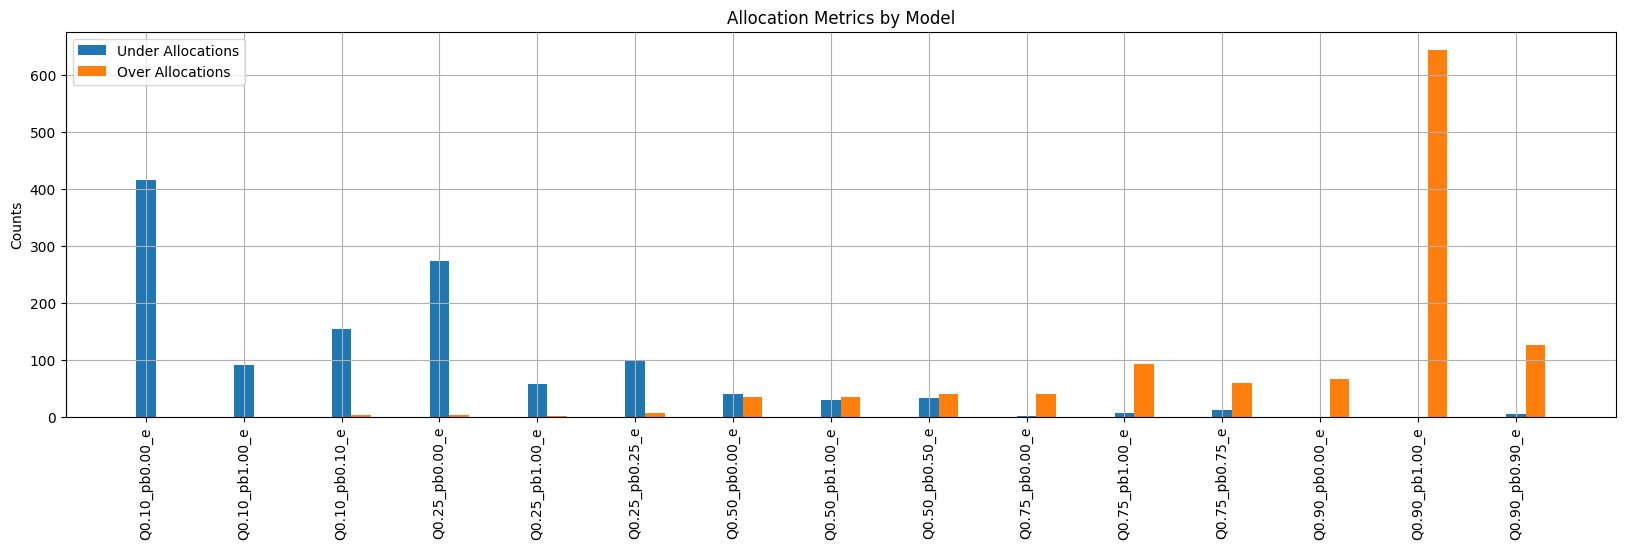

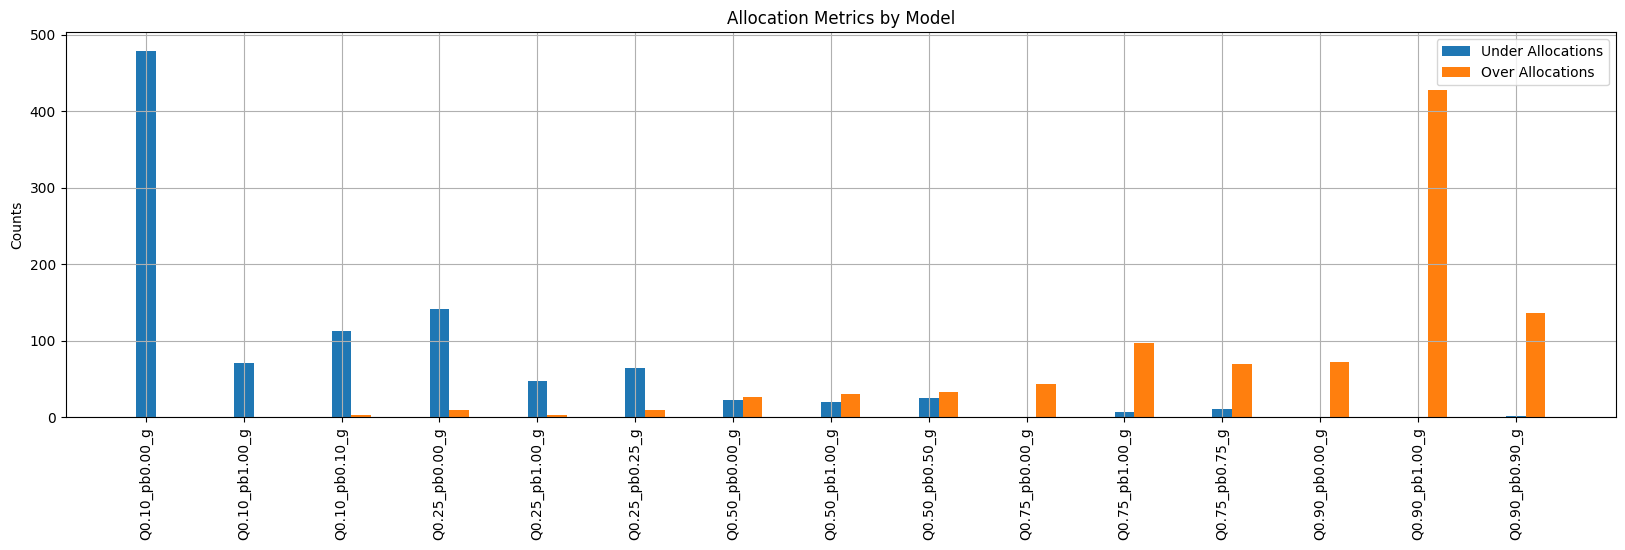

,Under Allocations,Over Allocations
Q0.10_pb0.00_g,479,0
Q0.10_pb1.00_g,71,0
Q0.10_pb0.10_g,113,3
Q0.25_pb0.00_g,141,9
Q0.25_pb1.00_g,48,3
Q0.25_pb0.25_g,65,9
Q0.50_pb0.00_g,23,27
Q0.50_pb1.00_g,20,30
Q0.50_pb0.50_g,25,33
Q0.75_pb0.00_g,1,43


In [256]:
# All Quantile Regressor Models plots for Under and Over Allocations

allocations_plot_under_over(regtrain_models_metrics_e)
allocations_plot_under_over(regtrain_models_metrics_g)

# Loading the chosen Models for Quantile Regressor

In [257]:
# NAMES of best models for both counts/scores criteria have been identified for both e/g datasets

# Model filename
best_counts_e_file = best_model_counts_e_name + '.joblib'
best_counts_g_file = best_model_counts_g_name + '.joblib'
best_scores_e_file = best_model_scores_e_name + '.joblib'
best_scores_g_file = best_model_scores_g_name + '.joblib'

# Load the actual MODEL
best_counts_e_model = load(join(model_path, best_counts_e_file))
best_counts_g_model = load(join(model_path, best_counts_g_file))

best_scores_e_model = load(join(model_path, best_scores_e_file))
best_scores_g_model = load(join(model_path, best_scores_g_file))

# Testing phase results
metric_path = PATH + '/metrics/'
all_metrics_gtest = pd.read_csv(metric_path + 'all_metrics_gtest.csv')
all_metrics_etest = pd.read_csv(metric_path + 'all_metrics_gtest.csv')

Plots not used

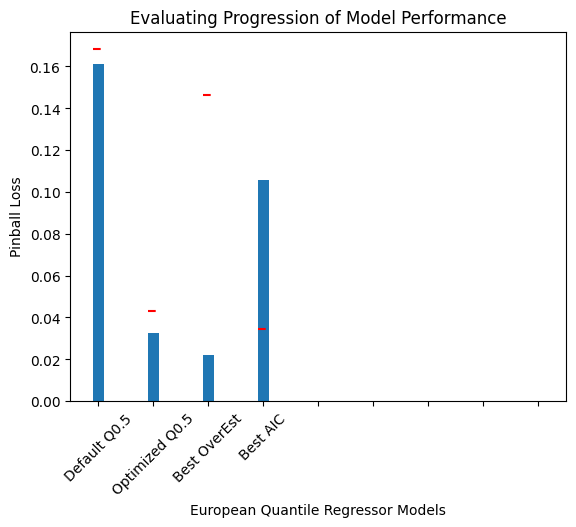

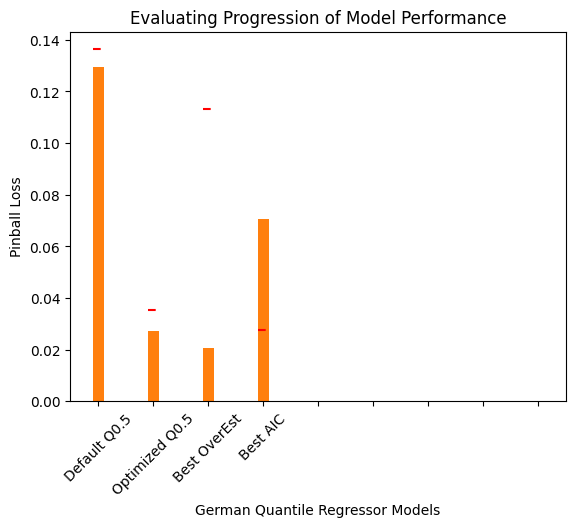

In [258]:
# Append results over TRAIN set (data is already saved and retrieved) to plot incremental bar plots


## European Dataset

### Best model based on overestimations
e_q_loss.append(regtrain_models_metrics_e['Pinball Loss At Alpha'].loc[best_model_counts_e_name])
e_q_cv.append(regtrain_models_metrics_e['Cross Validation'].loc[best_model_counts_e_name])
### Best model based on AIC/BIC scores
e_q_loss.append(regtrain_models_metrics_e['Pinball Loss At Alpha'].loc[best_model_scores_e_name])
e_q_cv.append(regtrain_models_metrics_e['Cross Validation'].loc[best_model_scores_e_name])

## German Dataset

### Best model based on overestimations
g_q_loss.append(regtrain_models_metrics_g['Pinball Loss At Alpha'].loc[best_model_counts_g_name])
g_q_cv.append(regtrain_models_metrics_g['Cross Validation'].loc[best_model_counts_g_name])
### Best model based on AIC/BIC scores
g_q_loss.append(regtrain_models_metrics_g['Pinball Loss At Alpha'].loc[best_model_scores_g_name])
g_q_cv.append(regtrain_models_metrics_g['Cross Validation'].loc[best_model_scores_g_name])

#plot incremental bar plots

incremental_bar(e_q_loss, e_q_cv, ['Default Q0.5', 'Optimized Q0.5', 'Best OverEst', 'Best AIC'], 5, 'European Quantile Regressor Models', 'Pinball Loss', plt.gca())
incremental_bar(g_q_loss, g_q_cv, ['Default Q0.5', 'Optimized Q0.5', 'Best OverEst', 'Best AIC'], 5, 'German Quantile Regressor Models', 'Pinball Loss', plt.gca(), color='#ff7f0e')


# Testing with the best models

For the **european** dataset, the best regressor model is the model trained for the *25% quantile* with penalization for *overestimations* (based on AIC/BIC scores).

For the **german** dataset, the best regressor model is the model trained for the *75% quantile* with penalization for *underestimations* (based on AIC/BIC scores).

For the **european** dataset, the best regressor model is the model trained for the *75% quantile* with penalization for *overestimations* (based on the count of underestimations).

For the **german** dataset, the best regressor model is the model trained for the *75% quantile* with penalization for *overestimations* (based on the count of underestimations).

In [259]:
# Predict TEST for the chosen best models
best_scores_e_pred = best_scores_e_model.predict(E_test)
best_scores_g_pred = best_scores_g_model.predict(G_test)
best_counts_e_pred = best_counts_e_model.predict(E_test)
best_counts_g_pred = best_counts_g_model.predict(G_test)

# Get results user evaluation functions
best_scores_e_res = eval_model(e_test_snr, best_scores_e_pred, 0)
best_scores_g_res = eval_model(g_test_snr, best_scores_g_pred, 1)
best_counts_e_res = eval_model(e_test_snr, best_counts_e_pred, 0)
best_counts_g_res = eval_model(g_test_snr, best_counts_g_pred, 0)

# Test the optimized classifier
best_clf_e_pred = clf_opt_e.predict(E_test)
best_clf_g_pred = clf_opt_g.predict(G_test)

# Get classifier results
best_clf_e_res = eval_model_classifier(e_test_mf, best_clf_e_pred)
best_clf_g_res = eval_model_classifier(g_test_mf, best_clf_g_pred)

<ipython-input-245-7590d15cf5c4>:39: RuntimeWarning: divide by zero encountered in log
  log_likelihood_est = np.log(q / scale) - q * np.abs(residuals) / scale
<ipython-input-245-7590d15cf5c4>:39: RuntimeWarning: divide by zero encountered in log
  log_likelihood_est = np.log(q / scale) - q * np.abs(residuals) / scale
<ipython-input-245-7590d15cf5c4>:39: RuntimeWarning: divide by zero encountered in log
  log_likelihood_est = np.log(q / scale) - q * np.abs(residuals) / scale


Plots not used

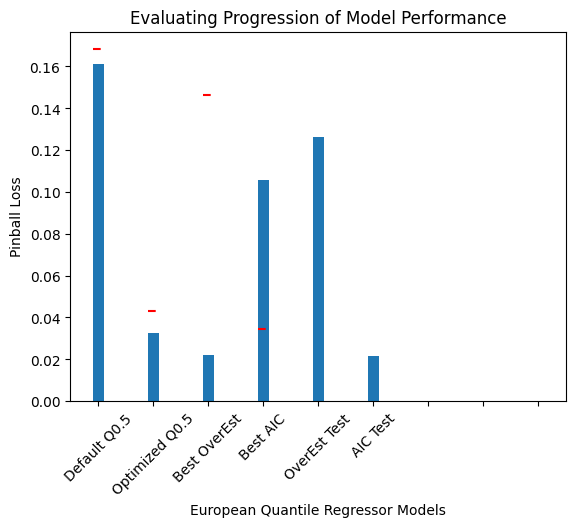

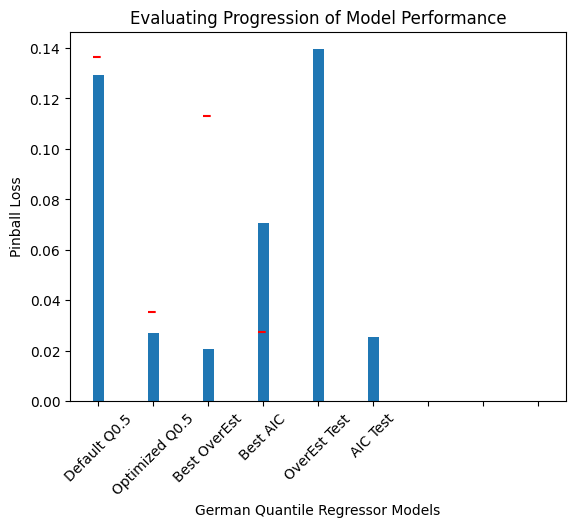

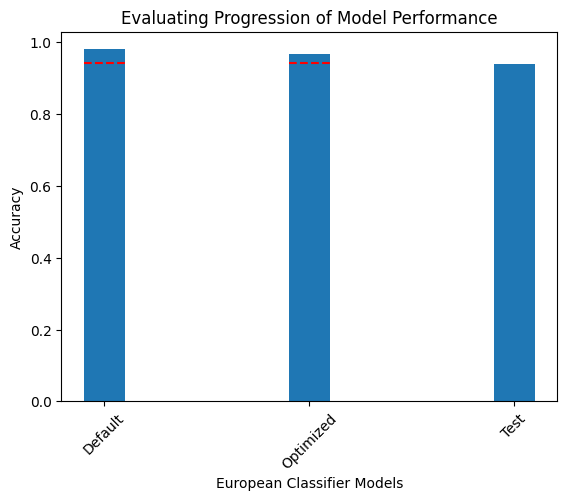

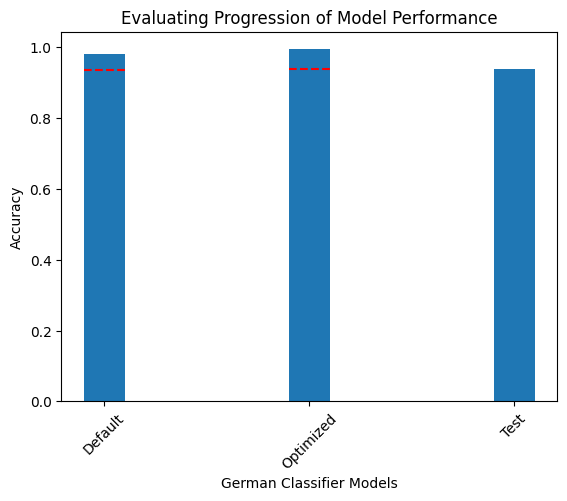

In [260]:
# Append results over TEST set (data is already saved and retrieved) to plot incremental bar plots


## European Dataset

### Best model based on overestimations
e_q_loss.append(best_counts_e_res['Pinball Loss At Alpha'])
e_q_cv.append(None)
### Best model based on AIC/BIC scores
e_q_loss.append(best_scores_e_res['Pinball Loss At Alpha'])
e_q_cv.append(None)
### Best Classifier
e_clf_acc.append(best_clf_e_res['Accuracy'])
e_clf_cv.append(None)

## German Dataset

### Best model based on overestimations
g_q_loss.append(best_counts_g_res['Pinball Loss At Alpha'])
g_q_cv.append(None)
### Best model based on AIC/BIC scores
g_q_loss.append(best_scores_g_res['Pinball Loss At Alpha'])
g_q_cv.append(None)
### Best Classifier
g_clf_acc.append(best_clf_g_res['Accuracy'])
g_clf_cv.append(None)

#plot incremental bar plots

#pineapple

incremental_bar(e_q_loss, e_q_cv, ['Default Q0.5', 'Optimized Q0.5', 'Best OverEst', 'Best AIC', 'OverEst Test', 'AIC Test'], 3, 'European Quantile Regressor Models', 'Pinball Loss', plt.gca())
incremental_bar(g_q_loss, g_q_cv, ['Default Q0.5', 'Optimized Q0.5', 'Best OverEst', 'Best AIC', 'OverEst Test', 'AIC Test'], 3, 'German Quantile Regressor Models', 'Pinball Loss', plt.gca())

incremental_bar(e_clf_acc, e_clf_cv, ['Default', 'Optimized', 'Test'], 0, 'European Classifier Models', 'Accuracy', plt.gca())
incremental_bar(g_clf_acc, g_clf_cv, ['Default', 'Optimized', 'Test'], 0, 'German Classifier Models', 'Accuracy', plt.gca())


In [261]:
best_scores_g_df = pd.DataFrame(best_scores_g_res, index=['C'])#['Best AIC: Q75PB1'])
best_counts_g_df = pd.DataFrame(best_counts_g_res, index=['B'])#['Best Alloc: Q75A0'])
best_clf_g_df = pd.DataFrame(best_clf_g_res, index=['A'])#['Best Classifier'])

col_names = ['Correct Allocations', 'Under Allocations', 'Over Allocations']

g_res = pd.concat([best_clf_g_df[col_names],best_counts_g_df[col_names],best_scores_g_df[col_names]],
                          ignore_index=False)

best_scores_e_df = pd.DataFrame(best_scores_e_res, index=['C'])#['Best AIC: Q25A0'])
best_counts_e_df = pd.DataFrame(best_counts_e_res, index=['B'])#['Best Alloc: Q75A0'])
best_clf_e_df = pd.DataFrame(best_clf_e_res, index=['A'])#['Best Classifier'])

e_res = pd.concat([best_clf_e_df[col_names], best_counts_e_df[col_names], best_scores_e_df[col_names]], ignore_index=False)

Final Allocations Results

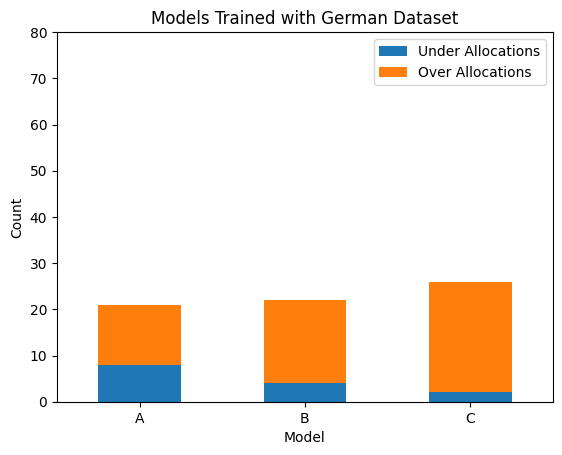

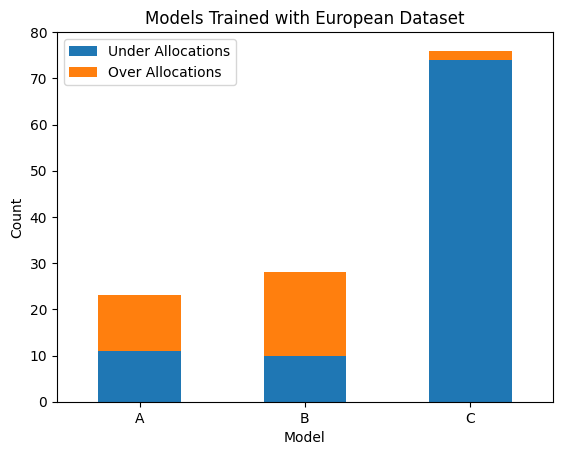

In [262]:
# Bar plot for final German Models
ax1 = g_res[['Under Allocations', 'Over Allocations']].plot.bar(stacked=True)
ax1.set_xlabel('Model')
ax1.set_ylabel('Count')
ax1.set_title('Models Trained with German Dataset')
ax1.set_xticklabels(labels=g_res.index.values, rotation=0)
ax1.set_ylim([0,80])
# Bar plot for final European Models
ax2 = e_res[['Under Allocations', 'Over Allocations']].plot.bar(stacked=True)
ax2.set_xlabel('Model')
ax2.set_ylabel('Count')
ax2.set_title('Models Trained with European Dataset')
ax2.set_xticklabels(labels=g_res.index.values, rotation=0)
ax2.set_ylim([0,80])
plt.show()

# Plotting TL results


In [263]:
# Load previous results

reg_pure_test = pd.read_csv(join(metrics_path, 'all_metrics_pure_tl_test_reg.csv'), index_col=0)
clf_pure_test = pd.read_csv(join(metrics_path, 'all_metrics_pure_tl_test_clf.csv'), index_col=0)

reg_da_test = pd.read_csv(join(metrics_path, 'all_metrics_adap_tl_test_reg.csv'), index_col=0)
clf_da_test = pd.read_csv(join(metrics_path, 'all_metrics_adap_tl_test_clf.csv'), index_col=0)

reg_da_train = pd.read_csv(join(metrics_path, 'all_metrics_adap_tl_train_reg.csv'), index_col=0)
clf_da_train = pd.read_csv(join(metrics_path, 'all_metrics_adap_tl_train_clf.csv'), index_col=0)

Allocation Results

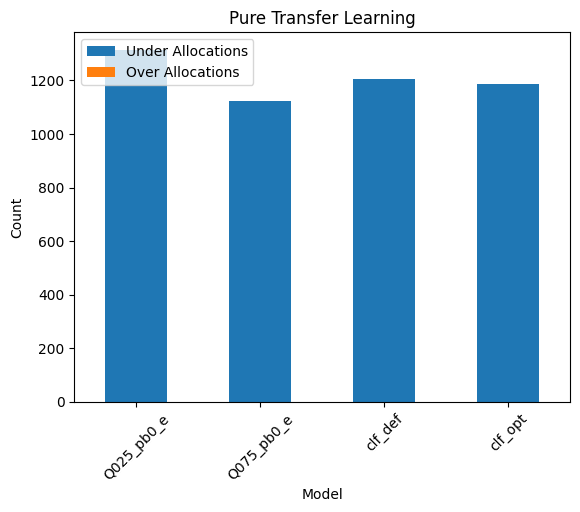

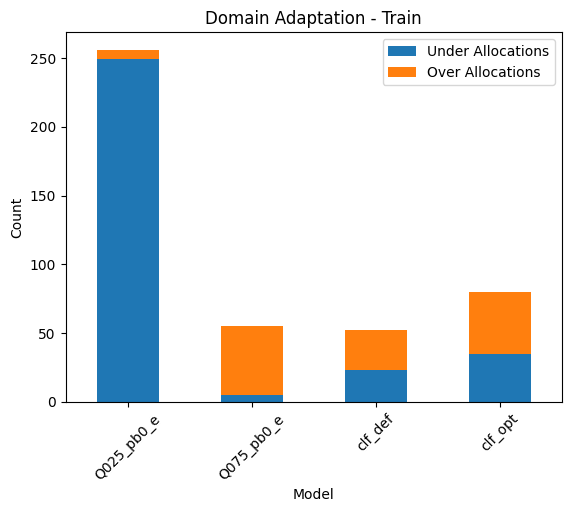

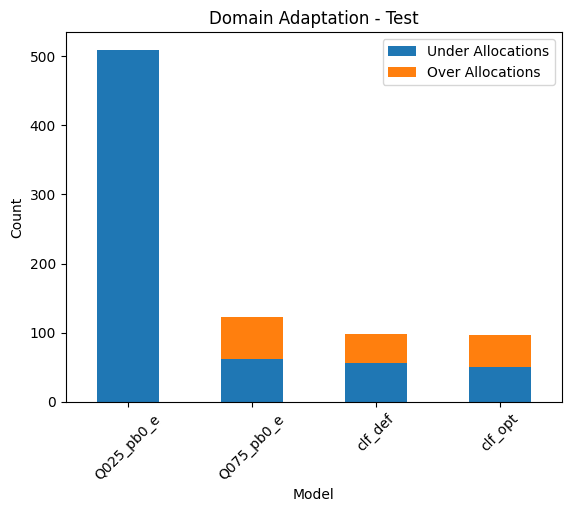

In [264]:
pure_res = pd.concat([reg_pure_test[col_names], clf_pure_test[col_names]])
#clf_da_trainOpt = clf_da_train.loc['clf_opt']
da_train_res = pd.concat([reg_da_train[col_names], clf_da_train[col_names]])
da_test_res = pd.concat([reg_da_test[col_names], clf_da_test[col_names]])


ax3 = pure_res[['Under Allocations', 'Over Allocations']].plot.bar(stacked=True)
ax3.set_xlabel('Model')
ax3.set_ylabel('Count')
ax3.set_title('Pure Transfer Learning')
ax3.set_xticklabels(labels=pure_res.index.values, rotation=45)


ax4 = da_train_res[['Under Allocations', 'Over Allocations']].plot.bar(stacked=True)
ax4.set_xlabel('Model')
ax4.set_ylabel('Count')
ax4.set_title('Domain Adaptation - Train')
ax4.set_xticklabels(labels=da_train_res.index.values, rotation=45)


ax5 = da_test_res[['Under Allocations', 'Over Allocations']].plot.bar(stacked=True)
ax5.set_xlabel('Model')
ax5.set_ylabel('Count')
ax5.set_title('Domain Adaptation - Test')
ax5.set_xticklabels(labels=da_test_res.index.values, rotation=45)


plt.show()



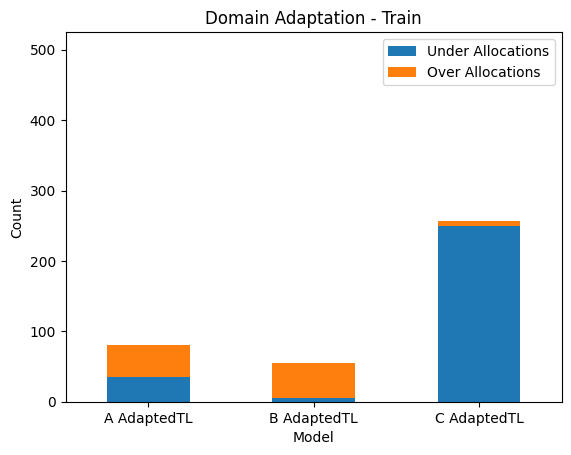

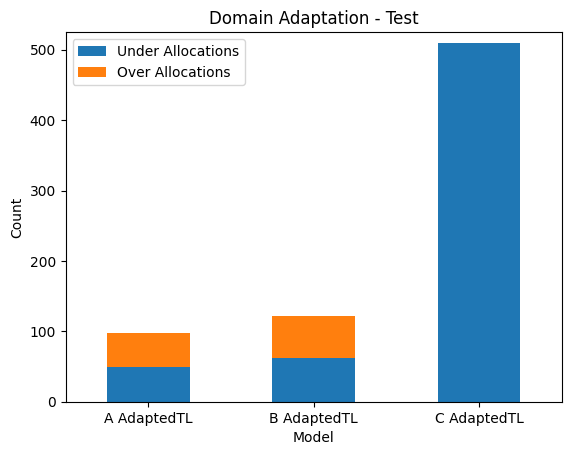

In [265]:
clf_da_train_opt = clf_da_train.loc[['clf_opt']]
clf_da_test_opt = clf_da_test.loc[['clf_opt']]


reg_da_train = reg_da_train.reindex(index=['Q075_pb0_e', 'Q025_pb0_e'])
reg_da_test = reg_da_test.reindex(index=['Q075_pb0_e', 'Q025_pb0_e' ])
da_train_res = pd.concat([clf_da_train_opt[col_names], reg_da_train[col_names]])
da_test_res = pd.concat([clf_da_test_opt[col_names], reg_da_test[col_names]])


ax4 = da_train_res[['Under Allocations', 'Over Allocations']].plot.bar(stacked=True)
ax4.set_xlabel('Model')
ax4.set_ylabel('Count')
ax4.set_title('Domain Adaptation - Train')
ax4.set_ylim([0,525])
ax4.set_xticklabels(labels=['A AdaptedTL', 'B AdaptedTL', 'C AdaptedTL'], rotation=0)


ax5 = da_test_res[['Under Allocations', 'Over Allocations']].plot.bar(stacked=True)
ax5.set_xlabel('Model')
ax5.set_ylabel('Count')
ax5.set_title('Domain Adaptation - Test')
ax5.set_xticklabels(labels=['A AdaptedTL', 'B AdaptedTL', 'C AdaptedTL'], rotation=0)
ax5.set_ylim([0,525])


plt.show()


How well our tranfer learning models performed over target domain (german dataset). Did the  tranfer learning models perform as well as the models trained soley for/with the german dataset?

In [266]:
reg_pure_test

,Mean Squared Error,Mean Pinball Loss,Pinball Loss At Alpha,Mean Absolute Error,R2 Square,D2 Pinball,Under Allocations,Over Allocations,Correct Allocations,Miss Rate
Model,,,,,,,,,,
Q025_pb0_e,7.575569,1.358185,0.00000,2.716369,-3.636953,-1.692485,1314,0,23,0.982797
Q075_pb0_e,5.377513,1.107760,0.00013,2.215519,-2.291538,-1.196039,1122,0,215,0.839192


In [267]:
clf_pure_test

,Accuracy,Precision,Recall,FScore,Under Allocations,Over Allocations,Correct Allocations,Miss Rate
Model,,,,,,,,
clf_def,0.099476,0.166458,0.046919,0.070586,1204,0,133,0.900524
clf_opt,0.112191,0.172420,0.056252,0.077764,1187,0,150,0.887809


In [268]:
reg_da_train

,Mean Squared Error,Mean Pinball Loss,Pinball Loss At Alpha,Mean Absolute Error,R2 Square,D2 Pinball,Under Allocations,Over Allocations,Correct Allocations,Miss Rate,Cross Validation
Model,,,,,,,,,,,
Q075_pb0_e,0.029179,0.044586,0.083966,0.089173,0.991000,0.939510,5,50,1745,0.030556,0.973149
Q025_pb0_e,0.528412,0.225033,0.021093,0.450067,0.837008,0.694699,249,7,1544,0.142222,0.808536


In [269]:
reg_da_test

,Mean Squared Error,Mean Pinball Loss,Pinball Loss At Alpha,Mean Absolute Error,R2 Square,D2 Pinball,Under Allocations,Over Allocations,Correct Allocations,Miss Rate
Model,,,,,,,,,,
Q075_pb0_e,0.071742,0.104305,0.105012,0.208610,0.956087,0.793224,62,60,1215,0.091249
Q025_pb0_e,1.714364,0.546300,0.001659,1.092601,-0.049350,-0.082994,509,0,828,0.380703


In [270]:
pure_res2 = pure_res.loc[['clf_opt', 'Q075_pb0_e', 'Q025_pb0_e']]



[Text(0, 0, 'A'),
 Text(1, 0, 'B'),
 Text(2, 0, 'C'),
 Text(3, 0, 'A Pure TL'),
 Text(4, 0, 'B PureTL'),
 Text(5, 0, 'C PureTL')]

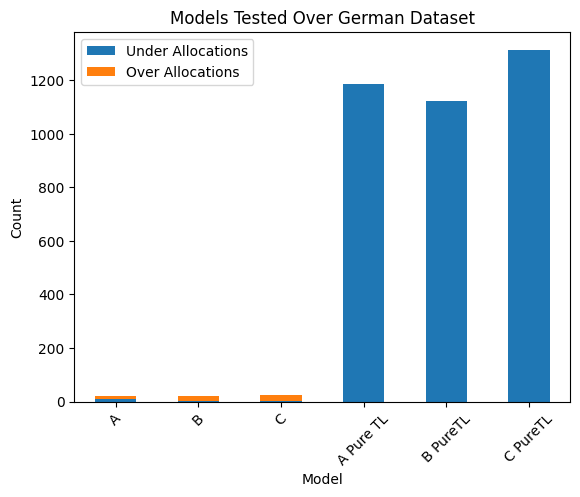

In [271]:
# Bar plot for final German Models

g_res2 = pd.concat([g_res, pure_res2[['Under Allocations', 'Over Allocations']]])
ax1 = g_res2[['Under Allocations', 'Over Allocations']].plot.bar(stacked=True)
ax1.set_xlabel('Model')
ax1.set_ylabel('Count')
ax1.set_title('Models Tested Over German Dataset')
labels = list(g_res.index) + ['A Pure TL', 'B PureTL', 'C PureTL']
#print(labels)
ax1.set_xticklabels(labels=labels, rotation=45)


pure TL performs very poorly! let's remove from the plot and focus on domain adaptation

['A', 'B', 'C', 'DA Best E AIC', 'DA Best E Alloc', 'DA Opt Clf']


[Text(0, 0, 'A'),
 Text(1, 0, 'B'),
 Text(2, 0, 'C'),
 Text(3, 0, 'DA Best E AIC'),
 Text(4, 0, 'DA Best E Alloc'),
 Text(5, 0, 'DA Opt Clf')]

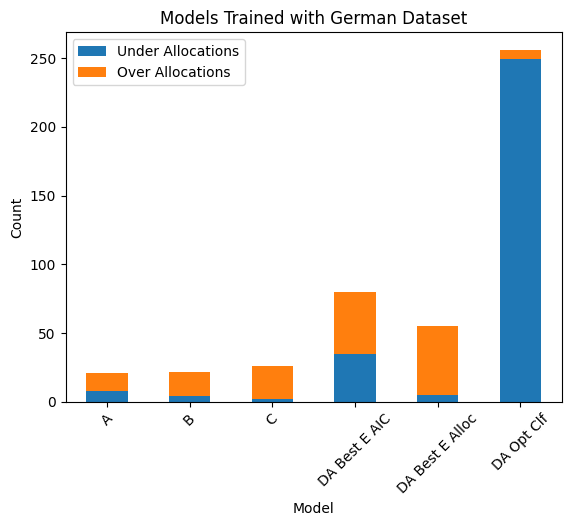

In [272]:
# Bar plot for final German Models
g_res2 = pd.concat([g_res, da_train_res[['Under Allocations', 'Over Allocations']]])
ax1 = g_res2[['Under Allocations', 'Over Allocations']].plot.bar(stacked=True)
ax1.set_xlabel('Model')
ax1.set_ylabel('Count')
ax1.set_title('Models Trained with German Dataset')
labels = list(g_res.index) + ['DA Best E AIC', 'DA Best E Alloc', 'DA Opt Clf']
print(labels)
ax1.set_xticklabels(labels=labels, rotation=45)


['A', 'B', 'C', 'clf_opt', 'Q075_pb0_e', 'Q025_pb0_e', 'clf_opt', 'Q075_pb0_e', 'Q025_pb0_e']


[Text(0, 0, 'A'),
 Text(1, 0, 'B'),
 Text(2, 0, 'C'),
 Text(3, 0, 'clf_opt'),
 Text(4, 0, 'Q075_pb0_e'),
 Text(5, 0, 'Q025_pb0_e'),
 Text(6, 0, 'clf_opt'),
 Text(7, 0, 'Q075_pb0_e'),
 Text(8, 0, 'Q025_pb0_e')]

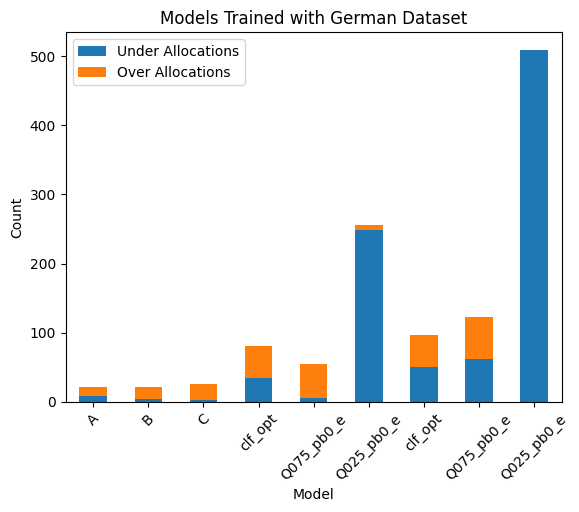

In [273]:
# Bar plot for final German Models
g_res2 = pd.concat([g_res, da_train_res[['Under Allocations', 'Over Allocations']], da_test_res[['Under Allocations', 'Over Allocations']]])
ax1 = g_res2[['Under Allocations', 'Over Allocations']].plot.bar(stacked=True)
ax1.set_xlabel('Model')
ax1.set_ylabel('Count')
ax1.set_title('Models Trained with German Dataset')
labels = list(g_res2.index)
print(labels)
ax1.set_xticklabels(labels=labels, rotation=45)


In [278]:
g_res

,Correct Allocations,Under Allocations,Over Allocations
A,314,8,13
B,313,4,18
C,309,2,24


['A', 'B', 'C', 'A Adapted TL', 'B Adapted TL', 'C Adapted TL']


[Text(0, 0, 'A'),
 Text(1, 0, 'B'),
 Text(2, 0, 'C'),
 Text(3, 0, 'A Adapted TL'),
 Text(4, 0, 'B Adapted TL'),
 Text(5, 0, 'C Adapted TL')]

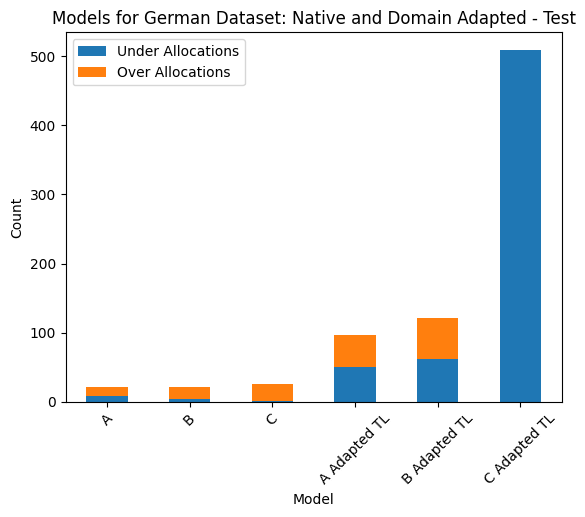

In [289]:
# Bar plot for final German Models
da_test_res2 = da_test_res.loc[['clf_opt', 'Q075_pb0_e', 'Q025_pb0_e']]

g_res2 = pd.concat([g_res, da_test_res2[['Under Allocations', 'Over Allocations']]])
ax1 = g_res2[['Under Allocations', 'Over Allocations']].plot.bar(stacked=True)
ax1.set_xlabel('Model')
ax1.set_ylabel('Count')
ax1.set_title('Models for German Dataset: Native and Domain Adapted - Test')
labels = list(g_res.index) + ['A Adapted TL', 'B Adapted TL', 'C Adapted TL']
print(labels)
ax1.set_xticklabels(labels=labels, rotation=45)



In [ ]:
g_clf_acc.append(clf_pure_test['Accuracy'].loc['clf_def'])
g_clf_acc.append(clf_pure_test['Accuracy'].loc['clf_opt'])
g_clf_cv.append(clftrain_def_metrics_g['Cross Validation'].iloc[0])
g_clf_cv.append(clftrain_opt_metrics_g['Cross Validation'].iloc[0])

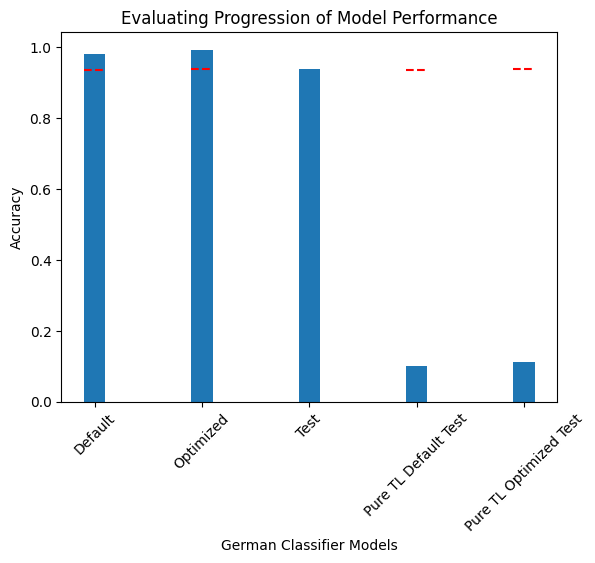

In [ ]:
incremental_bar(g_clf_acc, g_clf_cv, ['Default', 'Optimized', 'Test', 'Pure TL Default Test', 'Pure TL Optimized Test'], 0, 'German Classifier Models', 'Accuracy', plt.gca())


In [ ]:
g_clf_acc.append(clf_da_train['Accuracy'].loc['clf_def'])
g_clf_acc.append(clf_da_train['Accuracy'].loc['clf_opt'])
g_clf_cv.append(clf_da_train['Cross Validation'].loc['clf_def'])
g_clf_cv.append(clf_da_train['Cross Validation'].loc['clf_opt'])


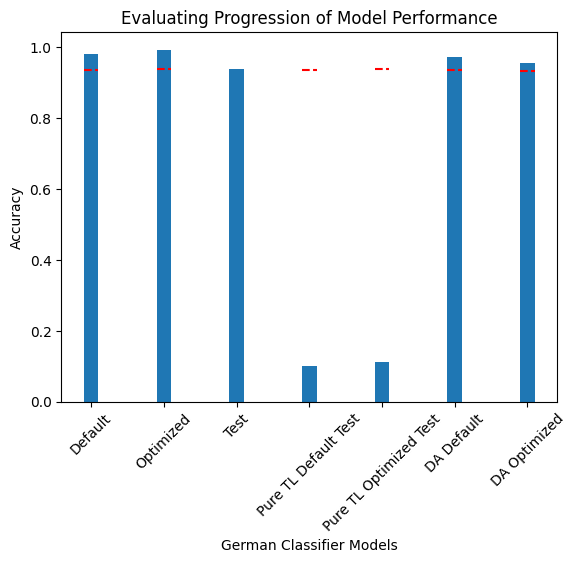

In [ ]:
incremental_bar(g_clf_acc, g_clf_cv, ['Default', 'Optimized', 'Test', 'Pure TL Default Test', 'Pure TL Optimized Test', 'DA Default', 'DA Optimized'], 0, 'German Classifier Models', 'Accuracy', plt.gca())


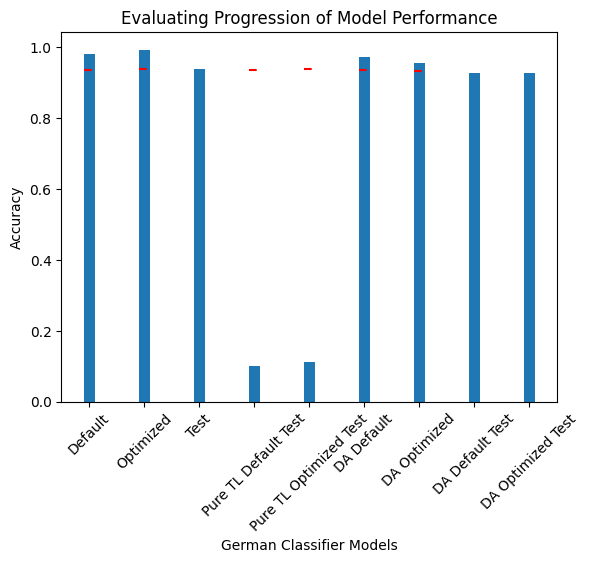

In [ ]:
g_clf_acc.append(clf_da_test['Accuracy'].loc['clf_def'])
g_clf_acc.append(clf_da_test['Accuracy'].loc['clf_opt'])
g_clf_cv.append(None)
g_clf_cv.append(None)
incremental_bar(g_clf_acc, g_clf_cv, ['Default', 'Optimized', 'Test', 'Pure TL Default Test', 'Pure TL Optimized Test', 'DA Default', 'DA Optimized', 'DA Default Test', 'DA Optimized Test'], 0, 'German Classifier Models', 'Accuracy', plt.gca())


In [ ]:
col_names = ['Over Allocations', 'Under Allocations', 'Correct Allocations']
best_clf_res_train_g = clftrain_opt_metrics_g[col_names].reset_index(drop=True)
best_counts_res_train_g = pd.DataFrame(regtrain_models_metrics_g[col_names].loc[best_model_counts_g_name]).T.reset_index(drop=True)
best_scores_res_train_g = pd.DataFrame(regtrain_models_metrics_g[col_names].loc[best_model_scores_g_name]).T.reset_index(drop=True)

# Concatenate the DataFrames
result_train_g = pd.concat([best_clf_res_train_g, best_counts_res_train_g, best_scores_res_train_g], axis=0)

# Reset the index
result_train_g.reset_index(drop=True, inplace=True)


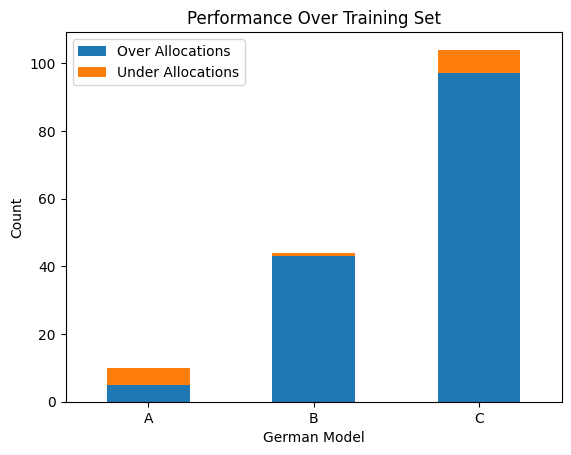

In [ ]:
col_names = ['Over Allocations', 'Under Allocations']

# Create DataFrame for each component with original indices
best_clf_res_train_g = clftrain_opt_metrics_g[col_names].reset_index()
best_counts_res_train_g = pd.DataFrame(regtrain_models_metrics_g[col_names].loc[best_model_counts_g_name]).T.reset_index()
best_scores_res_train_g = pd.DataFrame(regtrain_models_metrics_g[col_names].loc[best_model_scores_g_name]).T.reset_index()

# Concatenate the DataFrames
result_train_g = pd.concat([best_clf_res_train_g, best_counts_res_train_g, best_scores_res_train_g])

# Set the index back to the original indices
result_train_g.set_index('index', inplace=True)

result_train_g.plot.bar(stacked=True)
ax = plt.gca()
ax.set_xticklabels(['A', 'B', 'C'], rotation=0)
ax.set_title('Performance Over Training Set')
ax.set_xlabel('German Model')
ax.set_ylabel('Count')
plt.show()

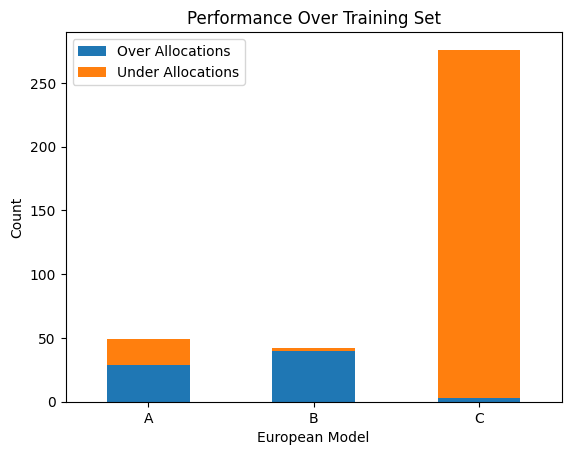

In [ ]:
# Create DataFrame for each component with original indices
best_clf_res_train_e = clftrain_opt_metrics_e[col_names].reset_index()
best_counts_res_train_e = pd.DataFrame(regtrain_models_metrics_e[col_names].loc[best_model_counts_e_name]).T.reset_index()
best_scores_res_train_e = pd.DataFrame(regtrain_models_metrics_e[col_names].loc[best_model_scores_e_name]).T.reset_index()

# Concatenate the DataFrames
result_train_e = pd.concat([best_clf_res_train_e, best_counts_res_train_e, best_scores_res_train_e])

# Set the index back to the original indices
result_train_e.set_index('index', inplace=True)

result_train_e.plot.bar(stacked=True)
ax = plt.gca()
ax.set_xticklabels(['A', 'B', 'C'], rotation = 0)
ax.set_title('Performance Over Training Set')
ax.set_xlabel('European Model')
ax.set_ylabel('Count')
plt.show()

In [ ]:
result_train_g.head()

,Over Allocations,Under Allocations
index,,
Opt_Clf_g,5,5
Q0.75_pb0.00_g,43,1
Q0.75_pb1.00_g,97,7


In [ ]:
clf_da_test[['Accuracy', 'Precision', 'Recall', 'FScore', 'Miss Rate','Under Allocations',
       'Over Allocations', 'Correct Allocations']]

,Accuracy,Precision,Recall,FScore,Miss Rate,Under Allocations,Over Allocations,Correct Allocations
Model,,,,,,,,
clf_def,0.926702,0.917746,0.945067,0.930623,0.073298,56,42,1239
clf_opt,0.927450,0.926327,0.944215,0.934973,0.072550,50,47,1240


In [ ]:
clf_da_train[['Accuracy', 'Precision', 'Recall', 'FScore', 'Miss Rate','Under Allocations',
       'Over Allocations', 'Correct Allocations']]

,Accuracy,Precision,Recall,FScore,Miss Rate,Under Allocations,Over Allocations,Correct Allocations
Model,,,,,,,,
clf_def,0.971111,0.979289,0.978230,0.978744,0.028889,23,29,1748
clf_opt,0.955556,0.968155,0.966227,0.967145,0.044444,35,45,1720


In [ ]:
reg_da_test[['Mean Squared Error', 'Mean Pinball Loss', 'Pinball Loss At Alpha',
       'Mean Absolute Error', 'R2 Square', 'D2 Pinball', 'Miss Rate',
       'Under Allocations', 'Over Allocations', 'Correct Allocations']]

,Mean Squared Error,Mean Pinball Loss,Pinball Loss At Alpha,Mean Absolute Error,R2 Square,D2 Pinball,Miss Rate,Under Allocations,Over Allocations,Correct Allocations
Model,,,,,,,,,,
Q025_pb0_e,1.714364,0.546300,0.001659,1.092601,-0.049350,-0.082994,0.380703,509,0,828
Q075_pb0_e,0.071742,0.104305,0.105012,0.208610,0.956087,0.793224,0.091249,62,60,1215


In [ ]:
reg_da_train[['Mean Squared Error', 'Mean Pinball Loss', 'Pinball Loss At Alpha',
       'Mean Absolute Error', 'R2 Square', 'D2 Pinball', 'Miss Rate',
       'Under Allocations', 'Over Allocations', 'Correct Allocations']]

,Mean Squared Error,Mean Pinball Loss,Pinball Loss At Alpha,Mean Absolute Error,R2 Square,D2 Pinball,Miss Rate,Under Allocations,Over Allocations,Correct Allocations
Model,,,,,,,,,,
Q025_pb0_e,0.528412,0.225033,0.021093,0.450067,0.837008,0.694699,0.142222,249,7,1544
Q075_pb0_e,0.029179,0.044586,0.083966,0.089173,0.991000,0.939510,0.030556,5,50,1745
